In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

使用正弦函数加上噪音生成一个序列数据集

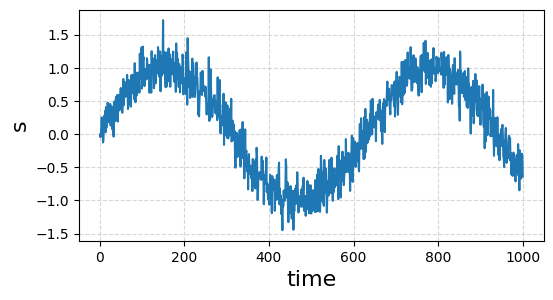

In [2]:
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
s = torch.sin(time * 0.01) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(6,3))
plt.grid(True, linestyle="--", alpha=0.5)
plt.plot(time, s)
plt.xlabel('time', fontsize=16)
plt.ylabel('s', fontsize=16)
plt.show()

使用马尔科夫假设，假设当前数据只和$\tau$个过去数据点有关。现有T=1000个数据[$x_1$...,$x_t$]，截取其中$\tau$个数据，将数据映射为$y_t$=$x_t$, $x_t$=[$x_t-\tau$...$x_t-1$]，其中$x_t$中只有$\tau$个数据

In [3]:
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = s[i:T - tau + i]
labels = s[tau:].reshape(-1, 1)

In [14]:
from torch.utils import data
import numpy as np

def Dataset(features, labels, batch_size):
    dataset = data.TensorDataset(*(features, labels))
    dataloader = data.DataLoader(dataset, batch_size, shuffle=True)
    return dataloader

batch_size=16
n_train=600

DataSet = Dataset(features[:n_train], labels[:n_train], batch_size)

In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight)

def Network():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

In [16]:
Loss = nn.MSELoss()

In [17]:
def train(net, dataset, epochs, loss, learning_rate):
    optimizer = torch.optim.Adam(net.parameters(), learning_rate)
    for epoch in range(epochs):
        for X, y in dataset:
            optimizer.zero_grad()
            loss = Loss(net(X), y)
            loss.backward()
            optimizer.step()
        print(f'epoch {epoch+1},loss {loss:f}')
net = Network()
train(net, DataSet, 10, Loss, 0.03)

epoch 1,loss 0.098552
epoch 2,loss 0.051622
epoch 3,loss 0.130137
epoch 4,loss 0.056254
epoch 5,loss 0.100598
epoch 6,loss 0.027020
epoch 7,loss 0.071149
epoch 8,loss 0.042339
epoch 9,loss 0.068374
epoch 10,loss 0.083844


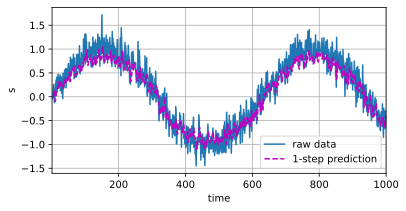

In [18]:
from d2l import torch as d2l
one_step_pre = net(features)
d2l.plot([time, time[tau:]], [s.detach().numpy(), one_step_pre.detach().numpy()],'time','s',legend=['raw data', '1-step prediction'],
        xlim=[1, 1000], figsize=(6,3))

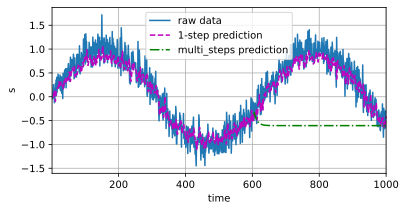

In [27]:
multi_steps_pre = torch.zeros(T)
multi_steps_pre[:n_train + tau] = s[:n_train + tau]

for i in range(n_train + tau, T):
    multi_steps_pre[i] = net(multi_steps_pre[i-tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]], 
          [s.detach().numpy(), one_step_pre.detach().numpy(), multi_steps_pre[n_train + tau:].detach().numpy()],
          'time', 's', legend=['raw data', '1-step prediction', 'multi_steps prediction'], xlim=[1, 1000], figsize=(6,3))

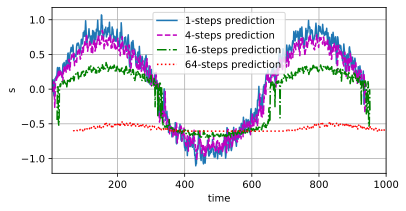

In [32]:
max_steps = 64

feature = torch.zeros(T-tau-max_steps+1, tau+max_steps)
for i in range(tau):
    feature[:, i] = s[i:i+T-tau-max_steps+1]

for i in range(tau, tau+max_steps):
    feature[:, i] = net(feature[:, i-tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps], 
          [feature[:, (tau+i-1)].detach().numpy() for i in steps],
          'time', 's', legend=[f'{i}-steps prediction' for i in steps], xlim=[5, 1000], figsize=(6,3))

Python切片操作的注释

In [46]:
g = torch.arange(10)
g

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

：操作符在索引后面[tau:]说明将从索引位置的元素开始到张量末尾的所有元素提取出来

In [48]:
g[tau:] 

tensor([4, 5, 6, 7, 8, 9])

:操作符在索引前面[:tau]说明将张量头部到索引位置的所有元素提取出来

In [49]:
g[:tau]

tensor([0, 1, 2, 3])

[2:tau]表示第2个位置到第tau个位置之间的所有元素

In [50]:
g[2:tau]

tensor([2, 3])

In [52]:
g.reshape(5,2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [55]:
feature

tensor([[-0.0059, -0.0464, -0.0169,  ..., -0.6047, -0.6048, -0.6049],
        [-0.0464, -0.0169,  0.1370,  ..., -0.6000, -0.6006, -0.6011],
        [-0.0169,  0.1370,  0.2525,  ..., -0.6004, -0.6009, -0.6014],
        ...,
        [-0.0393, -0.3274,  0.0671,  ..., -0.6051, -0.6052, -0.6052],
        [-0.3274,  0.0671,  0.0851,  ..., -0.6015, -0.6019, -0.6023],
        [ 0.0671,  0.0851,  0.2421,  ..., -0.6041, -0.6042, -0.6044]],
       grad_fn=<CopySlices>)

In [64]:
c = torch.rand(5, 5)
c

tensor([[0.0062, 0.4482, 0.1625, 0.0493, 0.4522],
        [0.7563, 0.7237, 0.5658, 0.3619, 0.9765],
        [0.7945, 0.2148, 0.7253, 0.5091, 0.1018],
        [0.6489, 0.5245, 0.9116, 0.2105, 0.0627],
        [0.3791, 0.7123, 0.4518, 0.7187, 0.8248]])

[:,4]表示保留矩阵中第4列的所有行里的元素。

In [74]:
c[:, 4]

tensor([0.4522, 0.9765, 0.1018, 0.0627, 0.8248])

[4,:]表示保留矩阵中第4行中的所有列中的元素

In [75]:
c[4,:]

tensor([0.3791, 0.7123, 0.4518, 0.7187, 0.8248])